In [1]:
import random

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn


from matplotlib import pyplot as plt
from datetime import datetime, timedelta

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    LeaveOneOut,
    GridSearchCV,
)


import warnings

warnings.filterwarnings("ignore")

In [2]:
df_sim = pd.read_excel('./Simusafe_Dataset/Feature_Simulation.xlsx')

df_sim.head()

,Unnamed: 0,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
0,0,0AC2A4,1,13,1,0,0,1,0,0,...,0.12420,0.07737,0.12307,0.07681,0.05046,0.03492,0.07430,0.05289,0.03606,0.02393
1,1,0AC2A4,1,32,0,1,0,1,0,0,...,0.20402,0.10296,0.14606,0.10325,0.03636,0.02433,0.05822,0.04136,0.02535,0.01391
2,2,0AC2A4,1,36,0,0,1,1,0,0,...,0.20329,0.12355,0.09483,0.08173,0.04524,0.02847,0.06055,0.04321,0.03586,0.01923
3,3,0AC2A4,1,42,1,0,0,0,0,0,...,0.20325,0.12153,0.11255,0.10920,0.04928,0.02923,0.07192,0.04653,0.03536,0.01832
4,4,0AC2A4,1,52,1,0,0,0,0,1,...,0.19645,0.13454,0.13270,0.13759,0.04501,0.02943,0.06175,0.04715,0.03511,0.01838


In [3]:
df_track = pd.read_excel('./Simusafe_Dataset/Feature_Track.xlsx')
df_track.head()

,Unnamed: 0,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
0,0,0AC2A4,1,7,1,1,0,0,1,0,...,0.13222,0.08812,0.13469,0.08590,0.05499,0.04078,0.08419,0.06275,0.03722,0.02711
1,1,0AC2A4,1,27,1,0,1,0,1,0,...,0.13639,0.08118,0.12483,0.07588,0.04060,0.02869,0.05951,0.04759,0.02963,0.01753
2,2,0AC2A4,1,33,1,0,0,1,1,0,...,0.19671,0.11480,0.10121,0.09079,0.04339,0.02727,0.06250,0.04305,0.03296,0.01751
3,3,0AC2A4,1,43,1,1,0,0,0,0,...,0.20826,0.12873,0.11832,0.11087,0.04872,0.02917,0.06894,0.04766,0.03627,0.01744
4,4,0AC2A4,1,58,1,1,0,0,0,0,...,0.21193,0.14454,0.13428,0.13604,0.04173,0.02743,0.05937,0.04344,0.03132,0.01762


In [4]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1287 non-null   int64  
 1   subject                        1287 non-null   object 
 2   lap                            1287 non-null   int64  
 3   start_time                     1287 non-null   int64  
 4   straight                       1287 non-null   int64  
 5   roundabout_entry               1287 non-null   int64  
 6   roundabout_exit                1287 non-null   int64  
 7   zebra_crossing                 1287 non-null   int64  
 8   left_turn                      1287 non-null   int64  
 9   u_turn                         1287 non-null   int64  
 10  bypass_dummy                   1287 non-null   int64  
 11  car                            1287 non-null   int64  
 12  pedestrian                     1287 non-null   i

In [6]:
# defining different data columns

scenario_data = [ 'subject', 'lap', 'start_time']
vehicular_data = ['max_speed', 'avg_speed', 'std_speed', 'yaw', 'yaw_rate', 'roll', 'roll_rate', 'pitch', 'pitch_rate', 'lat_acce', 'long_acce', 'vert_acce', 
                  'avg_acce_pedal_pos', 'std_acce_pedal_pos', 'avg_steer_angle', 'std_steer_angle']
neurophysiological_data = [ 'hr', 'hrv_lf', 'hrv_hf', 'hrv_lfhf_ratio', 'gsr_tonic', 'gsr_phasic', 'gsr_peaks', 'EBRmean', 'BDmean', 'ThetaFrontal', 'ThetaParietal',
                            'AlphaFrontal', 'AlphaParietal', 'LowerAlphaFrontal', 'LowerAlphaParietal', 'UpperAlphaFrontal', 'UpperAlphaParietal', 'BetaFrontal', 'BetaParietal',
                            'LowerBetaFrontal', 'LowerBetaParietal', 'UpperBetaFrontal', 'UpperBetaParietal']



In [7]:
scenario_df = df_sim[scenario_data]
vehicular_df = df_sim[vehicular_data]
neurophysiological_df = df_sim[neurophysiological_data]

scenario_df_track = df_track[scenario_data]
vehicular_df_track = df_track[vehicular_data]
neurophysiological_df_track = df_track[neurophysiological_data]

print(scenario_df.info())
print(vehicular_df.info())
print(neurophysiological_df.info())

print(scenario_df_track.info())
print(vehicular_df_track.info())
print(neurophysiological_df_track.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject     1287 non-null   object
 1   lap         1287 non-null   int64 
 2   start_time  1287 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 30.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   max_speed           1237 non-null   float64
 1   avg_speed           1237 non-null   float64
 2   std_speed           1237 non-null   float64
 3   yaw                 1238 non-null   float64
 4   yaw_rate            1238 non-null   float64
 5   roll                1238 non-null   float64
 6   roll_rate           1238 non-null   float64
 7   pitch               1238 non-null   float64
 8   pitch_rate          1238 non-null   

In [8]:
# subject is categorical data 

scenario_df['subject'] = scenario_df['subject'].astype('category')

scenario_df_track['subject'] = scenario_df_track['subject'].astype('category')

scenario_df.describe()

,lap,start_time
count,1287.000000,1287.000000
mean,3.957265,78.383838
std,1.976662,49.905419
min,1.000000,2.000000
25%,2.000000,39.000000
50%,4.000000,74.000000
75%,6.000000,109.000000
max,7.000000,400.000000


# CORRELATION OF SPECIFIC DATA IN SIMULATE DATA VS TRACK DATA

<Axes: >

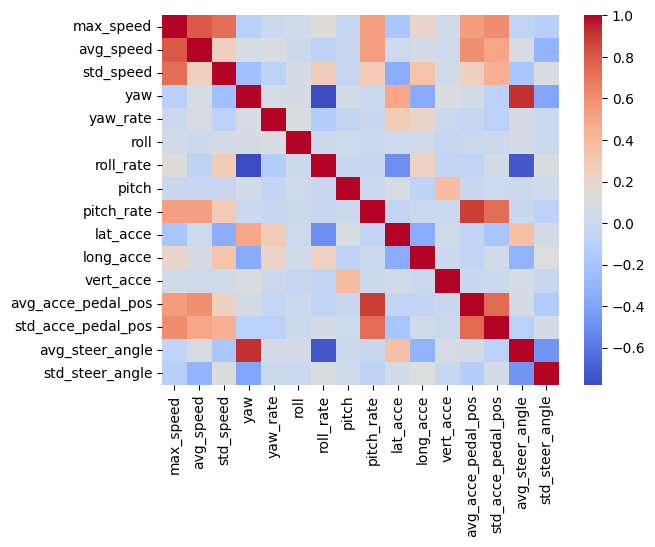

In [9]:
# plot correlation between scenario data of both datasets

numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

new_vehicular_df = vehicular_df.select_dtypes(include=numerics)
sns.heatmap(new_vehicular_df.corr(), annot=False, cmap="coolwarm")

<Axes: >

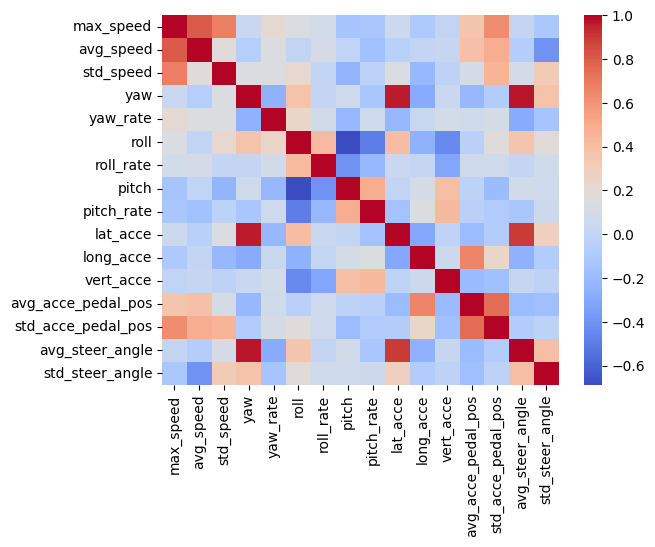

In [10]:
new_vehicular_df_track = vehicular_df_track.select_dtypes(include=numerics)
sns.heatmap(new_vehicular_df_track.corr(), annot=False, cmap="coolwarm")

<Axes: >

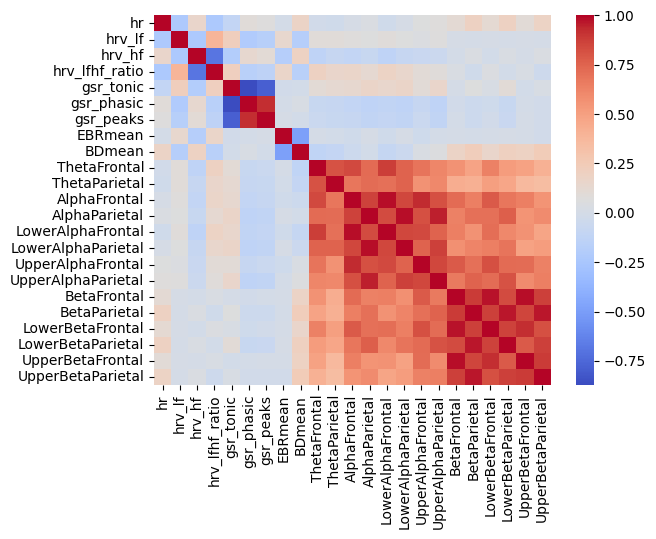

In [11]:
# plot correlation between neurophysiological data of both datasets

new_neurophysiological_df = neurophysiological_df.select_dtypes(include=numerics)
sns.heatmap(new_neurophysiological_df.corr(), annot=False, cmap="coolwarm")

<Axes: >

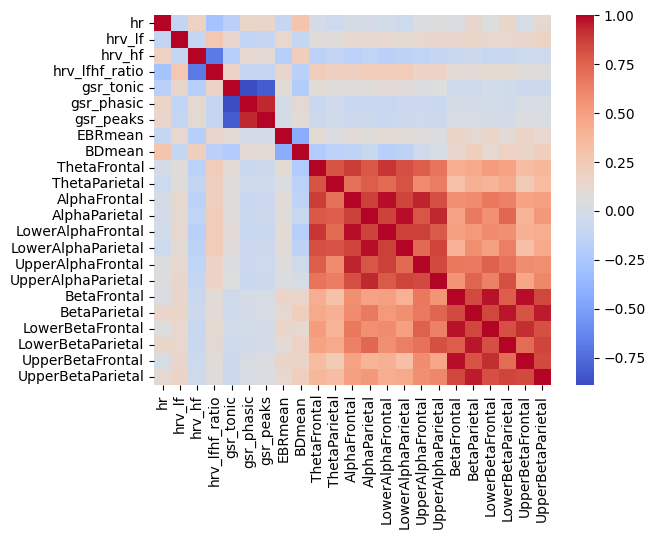

In [12]:
sns.heatmap(neurophysiological_df_track.select_dtypes(include=numerics).corr(), annot=False, cmap="coolwarm")

In [14]:
"""
straight
roundabout_entry
roundabout_exit
zebra_crossing
left_turn
u_turn
bypass_dummy
car
pedestrian
traffic_light
narrow_road
dummy
bend
habituation
traffic
hurry
frustration
surprise
risk_outcome
risk_source_env
risk_source_other_usr
risk_source_driver
risk_source_crash
risk_evaluation
violation_no
violation_roadside_invasion
violation_give_the_way
violation_road_signs
violation_heavy_braking
violation_roadside_exit
violation_slowdown
emotion_na
emotion_neutral
emotion_surprise
emotion_anger
emotion_boredom
emotion_fear
emotion_fun
gaze_na
gaze_complete_expl
gaze_partial_expl
gaze_poor_expl
distraction_na
distraction_no
distraction_reduced_attention
distraction_speaking

"""
emotional_data = ['emotion_na', 'emotion_neutral', 'emotion_surprise', 'emotion_anger', 'emotion_boredom', 'emotion_fear', 'emotion_fun']
gaze_data = ['gaze_na', 'gaze_complete_expl', 'gaze_partial_expl', 'gaze_poor_expl']
distraction_data = ['distraction_na', 'distraction_no', 'distraction_reduced_attention', 'distraction_speaking']
risk_data = ['risk_outcome', 'risk_source_env', 'risk_source_other_usr', 'risk_source_driver', 'risk_source_crash', 'risk_evaluation']
violation_data = ['violation_no', 'violation_roadside_invasion', 'violation_give_the_way', 'violation_road_signs', 'violation_heavy_braking', 'violation_roadside_exit', 'violation_slowdown']
road_data = ['straight', 'roundabout_entry', 'roundabout_exit', 'zebra_crossing', 'left_turn', 'u_turn', 'bypass_dummy', 'car', 'pedestrian', 'traffic_light', 'narrow_road', 'dummy', 'bend', 'habituation', 'traffic', 'hurry', 'frustration', 'surprise']



In [59]:
# Correlation of Neurophysiological data with emotional data
heart_data = ['hr', 'hrv_lf', 'hrv_hf', 'hrv_lfhf_ratio']
brain_data = ['ThetaFrontal', 'ThetaParietal', 'AlphaFrontal', 'AlphaParietal', 'LowerAlphaFrontal', 'LowerAlphaParietal', 'UpperAlphaFrontal', 'UpperAlphaParietal', 'BetaFrontal', 'BetaParietal', 'LowerBetaFrontal', 'LowerBetaParietal', 'UpperBetaFrontal', 'UpperBetaParietal']
gsr_data = ['gsr_tonic', 'gsr_phasic', 'gsr_peaks']
data_to_plot = emotional_data + brain_data + heart_data + gsr_data
emotional_neuro_data = df_track[data_to_plot]
emotional_neuro_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   emotion_na          1056 non-null   int64  
 1   emotion_neutral     1056 non-null   int64  
 2   emotion_surprise    1056 non-null   int64  
 3   emotion_anger       1056 non-null   int64  
 4   emotion_boredom     1056 non-null   int64  
 5   emotion_fear        1056 non-null   int64  
 6   emotion_fun         1056 non-null   int64  
 7   ThetaFrontal        809 non-null    float64
 8   ThetaParietal       809 non-null    float64
 9   AlphaFrontal        809 non-null    float64
 10  AlphaParietal       809 non-null    float64
 11  LowerAlphaFrontal   809 non-null    float64
 12  LowerAlphaParietal  809 non-null    float64
 13  UpperAlphaFrontal   809 non-null    float64
 14  UpperAlphaParietal  809 non-null    float64
 15  BetaFrontal         809 non-null    float64
 16  BetaPa

In [60]:
emotional_neuro_data.dropna(inplace=True)

In [61]:
sorted_corr = emotional_neuro_data.corr().sort_values('emotion_surprise', ascending=False)
print(sorted_corr['emotion_surprise'])

#plotting the sorted correlation
plt.figure(figsize=(10, 10))

emotion_surprise      1.000000
emotion_fun           0.328322
hr                    0.041520
LowerBetaFrontal      0.012647
BetaFrontal           0.009407
gsr_phasic            0.006078
UpperBetaFrontal      0.005695
LowerBetaParietal    -0.001311
gsr_peaks            -0.007618
BetaParietal         -0.009961
ThetaParietal        -0.010930
UpperBetaParietal    -0.017651
ThetaFrontal         -0.017683
LowerAlphaParietal   -0.019991
AlphaParietal        -0.024524
hrv_lfhf_ratio       -0.025967
LowerAlphaFrontal    -0.026503
AlphaFrontal         -0.027638
UpperAlphaFrontal    -0.028372
UpperAlphaParietal   -0.029520
hrv_hf               -0.032832
gsr_tonic            -0.058298
hrv_lf               -0.077324
emotion_neutral      -0.476951
emotion_na                 NaN
emotion_anger              NaN
emotion_boredom            NaN
emotion_fear               NaN
Name: emotion_surprise, dtype: float64


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Axes: >

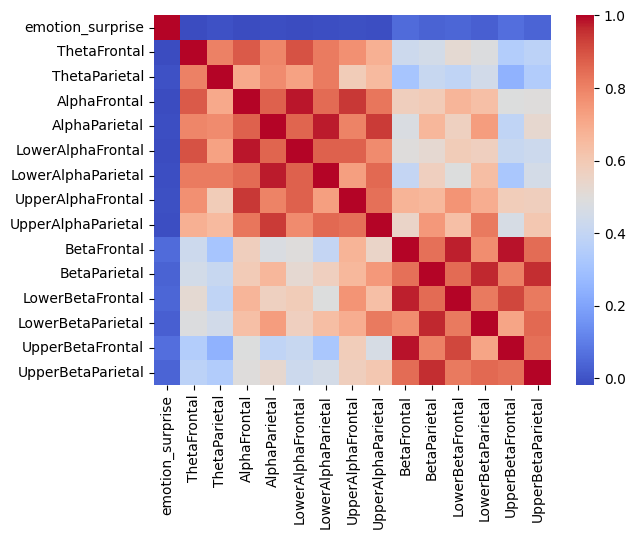

In [57]:
neuro_surprise_data = ['emotion_surprise'] + brain_data

sns.heatmap(emotional_neuro_data[neuro_surprise_data].corr(), annot=False, cmap="coolwarm")